# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [183]:
# Declaring the threads because of warning in KMeans for data leakage
import os
os.environ['OMP_NUM_THREADS'] = '4'
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

We will begin our analysis by importing the data, scaling it, and applying Principal Component Analysis (PCA) to examine the explained variance of the first 10 components and decide on how many should be use. Through our analyses we will keep drop Løsgænger as it is represented by only 3 candidates which migth harm more than help our analyses. 

In [184]:
data = pd.read_excel('alldata.xlsx')
data = data.dropna()

# Drop Løsgænger
data = data[data['parti'] != 'Løsgænger']

labels = data['parti']
data_num = data.drop(columns=['storkreds', 'alder', 'navn', 'parti'])



scaler = StandardScaler()
scaler.fit(data_num)
X_scaled= scaler.transform(data_num)

# We start with 10 components to see which has most variance
pca = PCA(n_components = 10)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)



X_pca = X_pca[labels != 'Løsgænger']

explained_variance_10 = [round(x, 4) for x in pca.explained_variance_ratio_]
print(f"""Original shape: {str(X_scaled.shape)}
Reduced shape: {str(X_pca.shape)}

The explained ratio of the 10 components: 
{explained_variance_10}

Sum of the explained ratio of the 10 components: {round(np.sum(explained_variance_10),4)}""")

Original shape: (864, 49)
Reduced shape: (864, 10)

The explained ratio of the 10 components: 
[0.4184, 0.1027, 0.0496, 0.043, 0.0292, 0.0237, 0.02, 0.017, 0.0168, 0.016]

Sum of the explained ratio of the 10 components: 0.7364


So we reduced the size of the features to 10 and as we can see these 10 features/components explain more than 70% of the data which is pretty good. Next we will try to plot a graph with explained variance by different components.

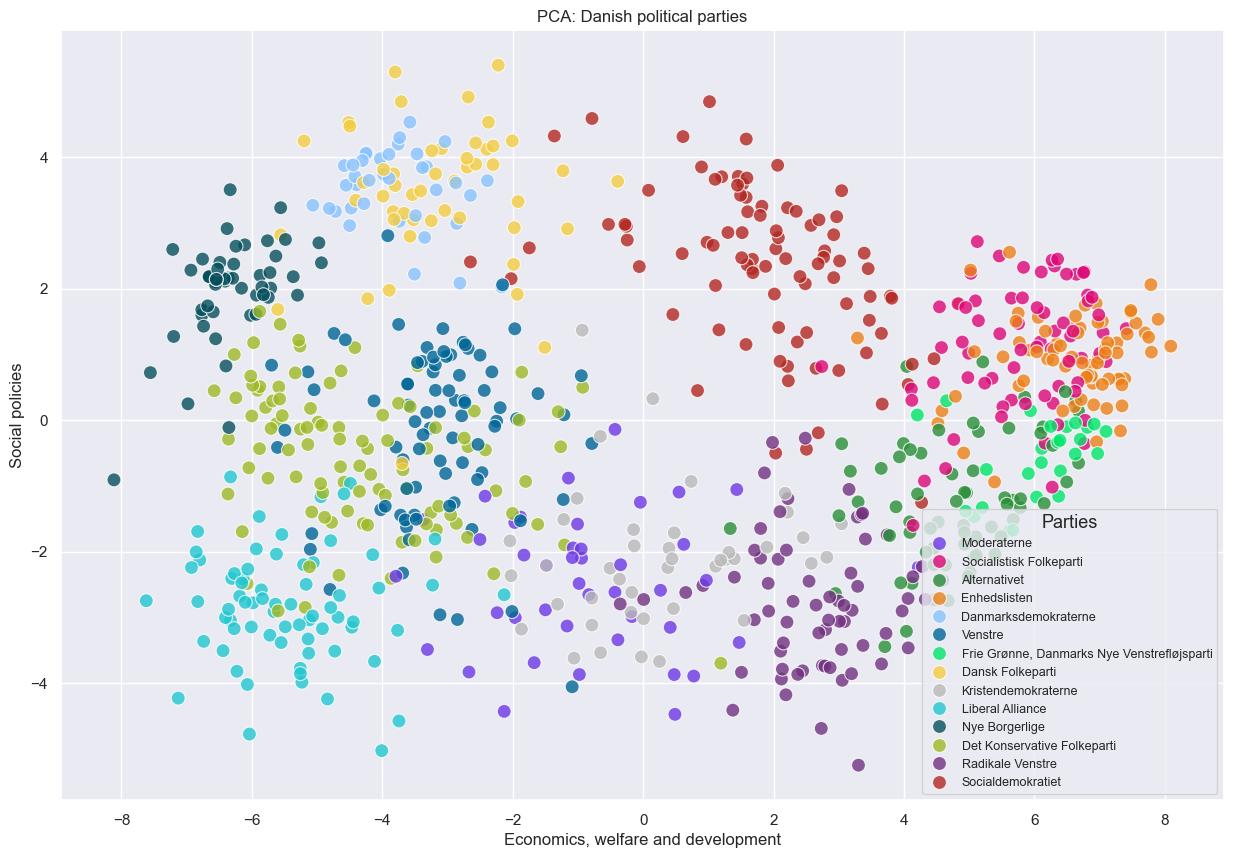

In [185]:
parti_colors = {
    "Moderaterne": '#6c39e5',
    "Socialistisk Folkeparti" : '#dd0878',
    "Alternativet" : '#2a8f39',
    "Enhedslisten" : '#ed8019',
    "Danmarksdemokraterne" : '#8ac3ff',
    "Venstre" : '#006697', 
    "Frie Grønne, Danmarks Nye Venstrefløjsparti" : "#00e66a",
    "Dansk Folkeparti" : '#f3cd41',
    "Kristendemokraterne" : '#bababa',
    "Liberal Alliance" : '#21c6cf',
    "Nye Borgerlige" : '#054f5c',
    "Det Konservative Folkeparti" : '#9eba27',
    "Radikale Venstre" : '#713280',
    "Socialdemokratiet" : '#b32722'
}


def visualize_2d_pca(x, labels, colors):
    sns.set_theme(rc={'figure.figsize':(15,10)})
    plot = sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=colors, s=100, alpha=0.8)
    plot.set(xlabel="Economics, welfare and development")
    plot.set(ylabel="Social policies")
    plt.title("PCA: Danish political parties")
    plot.legend(fontsize=9, title='Parties', title_fontsize=13)
    
    plt.grid(True)
    plt.show()

visualize_2d_pca(X_pca, labels, parti_colors)

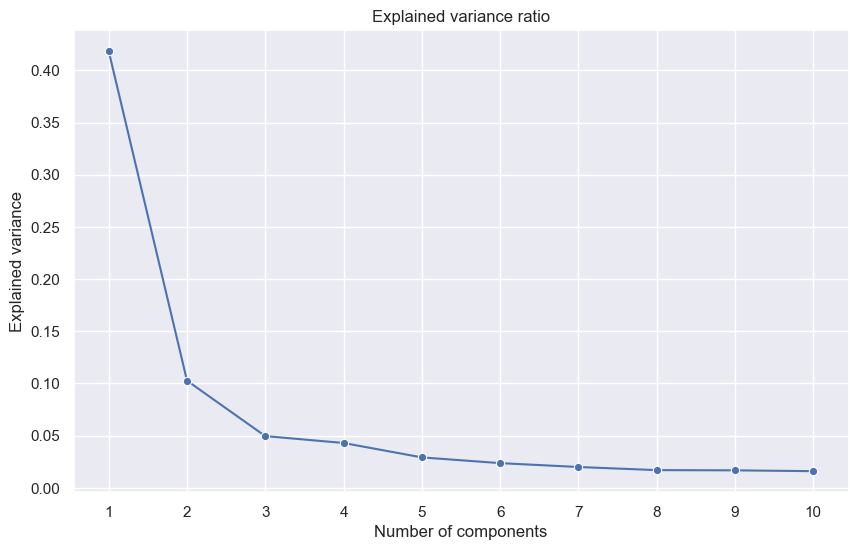

Sum of the first three explained variances: 0.5707


In [186]:
plt.figure(figsize=(10, 6))

sns.lineplot(x=list(range(1, 1 + len(explained_variance_10))), y=explained_variance_10, marker='o')

plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid(True)
plt.title('Explained variance ratio')
plt.xticks(np.arange(1, 1 + len(explained_variance_10)))
plt.show()

print(f"Sum of the first three explained variances: {sum(explained_variance_10[:3])}")

Although our 10 components explain over 70% of the variance in the data, we can observe that after the 3rd component, the explained variance levels off. This suggests that using just the first 3 components would capture almost 57% of the total variance. While this is less than 70%, the first 3 components still explain over 75% of the variance covered by all 10 components combined. Further testing with model training would be necessary to determine how models perform with 3 versus 10 components.

For now, we will focus on the first two components and identify which features (questions) contributed the most to their formation. After that, we will assess how well this PCA decomposition aligns with the political compass framework.

In [187]:
components = pca.components_
feature_names = data_num.columns

def get_top_features(component, feature_names, num_top_features=5):
    component_features = [(feature_names[i], component[i]) for i in range(len(feature_names))]
    component_features.sort(key=lambda x: abs(x[1]), reverse=True)
    return component_features[:num_top_features]

important_features = []
for i in range(2):
    top_features = get_top_features(components[i], feature_names)
    important_features.append(top_features)
    print(f"\nPrincipal Component {i+1}:")
    for feature, coefficient in top_features:
        print(f"{feature}: {coefficient}")

component_1_features = [feature for feature, _ in important_features[0]]
component_2_features = [feature for feature, _ in important_features[1]]


Principal Component 1:
530: 0.19034572689000526
537: -0.1900891516020483
4a: 0.1887487277841507
3b: 0.18868268556430126
550: 0.18836433408651637

Principal Component 2:
10b: 0.302021761449837
556: -0.2977915002269517
551: 0.2938591544248491
553: 0.2743341371957045
4b: 0.2570756680936026


We can see here the 5 features which helped the most when creating the components. Now we will see what question stands behind these features. First we will model the questions into one DataFrame.

In [188]:
dr_q = pd.read_excel('drq.xlsx')
tv2_q = pd.read_excel('tv2q.xlsx')

tv2_q.rename(columns={'id': 'ID', 'header':'Title', 'question': 'Question' }, inplace=True)

combined_q = pd.concat([dr_q, tv2_q])
combined_q = combined_q[['ID', 'Title', 'Question']]
combined_q['ID'] = combined_q['ID'].astype(str)
combined_q

,ID,Title,Question
0,530,KLIMA OG ENERGI,Danmark skal bruge flere penge på at styrke to...
1,531,ARBEJDSMARKED OG ØKONOMI,Der skal indføres en særlig skat på de allerhø...
2,533,RET OG STRAF,Kriminalitet begået i udsatte boligområder ska...
3,534,EU OG UDENRIGS,På sigt skal Danmark meldes ud af EU
4,535,EU OG UDENRIGS,"Det er fornuftigt, at Danmark i de kommende år..."
...,...,...,...
69,10b,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed ..."
70,11a,Mink-sagen,Der har været alt for meget fokus på Mette Fre...
71,11b,Mink-sagen,"Det bør undersøges, om Mette Frederiksen kan s..."
72,12a,Coronavirus,"Hvis coronasmitten stiger markant til vinter, ..."


Next we will extract the questions that are most important for the components.

In [189]:
print("Component 1:")
combined_q[combined_q['ID'].isin(component_1_features)]

Component 1:


,ID,Title,Question
0,530,KLIMA OG ENERGI,Danmark skal bruge flere penge på at styrke to...
5,537,VELFÆRD,"Det er okay, at den økonomiske ulighed stiger,..."
15,550,ARBEJDSMARKED OG ØKONOMI,"Der skal indføres kvoter, der sikrer mindst 30..."
55,3b,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.
56,4a,Økonomi,Den økonomiske ulighed i det danske samfund bø...


### Translation of features in component 1

| Question ID | Title                    | Description                                        |
|-------------|--------------------------|----------------------------------------------------|
| 530         | CLIMATE AND ENERGY       | Should Denmark prioritize funding for public transportation over new highway construction to address environmental concerns and enhance accessibility?                                                                                |
| 537         | WELFARE                  | Is it acceptable for economic inequality to increase if the general wealth of Danes also rises?                                           |
| 550         | LABOR MARKET AND ECONOMY | Should there be quotas ensuring at least 30% female representation on company boards?                                                             |
| 3b          | Foreign and Defense Policy | Should Denmark increase its foreign aid budget?  |
| 4a          | Economy                  | Should economic inequality in Danish society be reduced?                                                                                      |

In [190]:
print("Component 2:")
display(combined_q[combined_q['ID'].isin(component_2_features)])

Component 2:


,ID,Title,Question
16,551,EU OG UDENRIGS,Der skal være permanent grænsekontrol mellem D...
18,553,UDDANNELSE,Der skal udflyttes flere uddannelsespladser fr...
20,556,ARBEJDSMARKED OG ØKONOMI,Den såkaldte Arne-pension skal afskaffes
57,4b,Økonomi,Staten bør i højere grad kompensere danskerne ...
69,10b,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed ..."


### Translation of features in component 2


| Question ID | Title                    |   Description |
|-------------|--------------------------|---------------|
| 551         | EU AND FOREIGN AFFAIRS   | Should Denmark implement permanent border controls with Germany, potentially impacting Schengen Area commitments? |
| 553         | EDUCATION                | Should educational opportunities be decentralized from major cities to smaller towns to avoid depopulation? |
| 556         | LABOR MARKET AND ECONOMY | Should the "Arne pension" be abolished due to its high cost and lack of targeted effectiveness?    |
| 4b          | Economy                  | Should the state increase compensation to Danes for the rising costs due to inflation?             |
| 10b         | Social Area              | Should the "Arne pension" allowing for early retirement be maintained despite labor shortages?     |

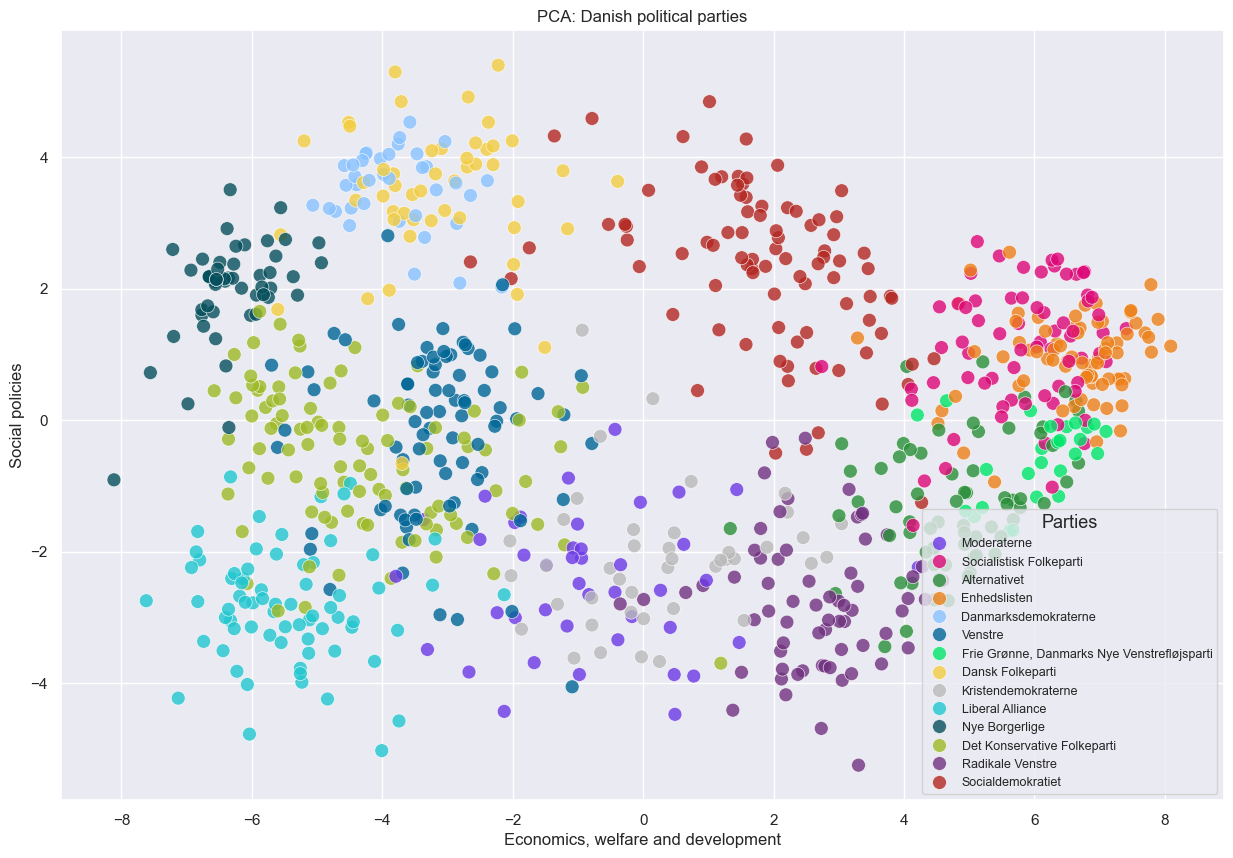

In [191]:
def visualize_2d_pca(x, labels, colors):
    sns.set_theme(rc={'figure.figsize':(15,10)})
    plot = sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=colors, s=100, alpha=0.8, edgecolor='w', linewidth=0.5)
    plot.set(xlabel="Economics, welfare and development")
    plot.set(ylabel="Social policies")
    plt.title("PCA: Danish political parties")
    plot.legend(fontsize=9, title='Parties', title_fontsize=13)
    
    plt.grid(True)
    plt.show()

visualize_2d_pca(X_pca, labels, parti_colors)

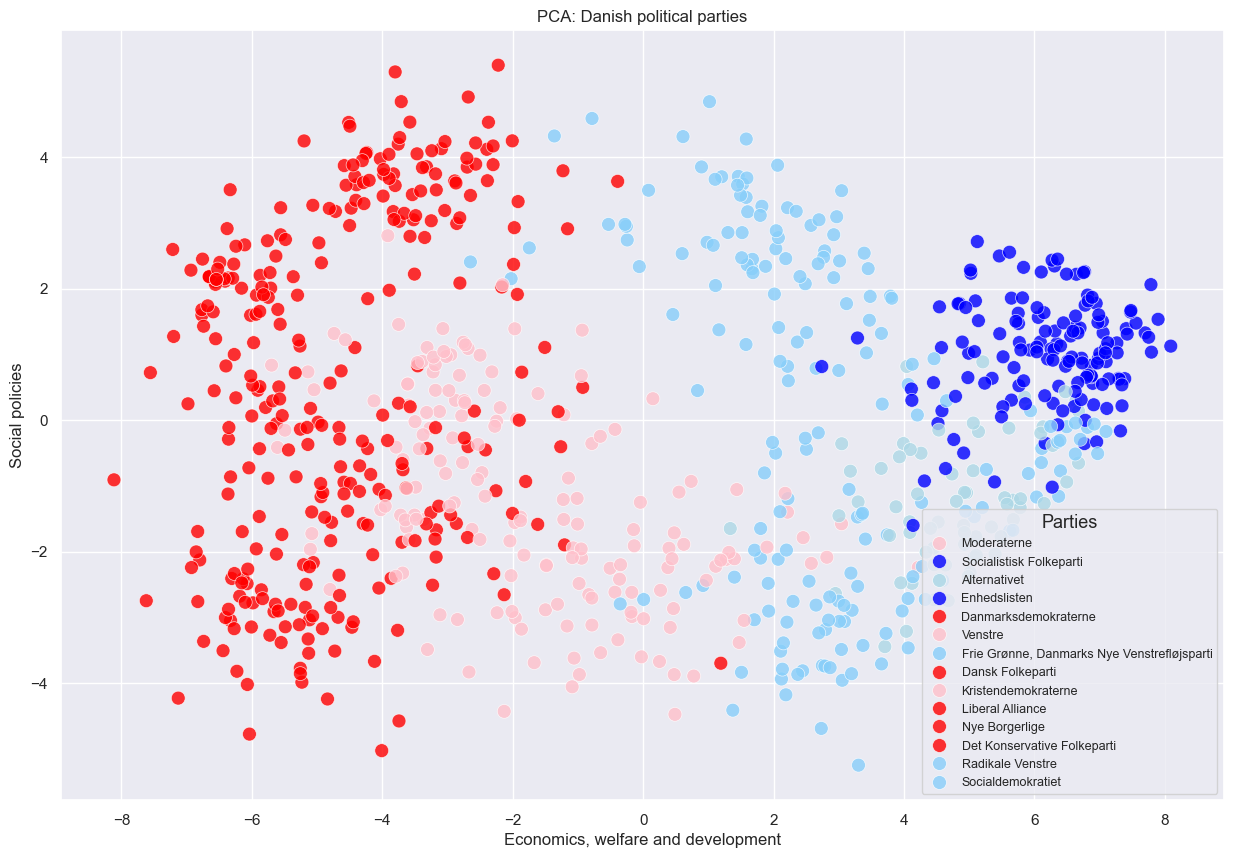

In [192]:
parti_left_right_colors = {
    "Moderaterne": 'pink',
    "Socialistisk Folkeparti" : 'blue',
    "Alternativet" : 'lightblue',
    "Løsgænger" : 'white',
    "Enhedslisten" : 'blue',
    "Danmarksdemokraterne" : 'red',
    "Venstre" : 'pink', 
    "Frie Grønne, Danmarks Nye Venstrefløjsparti" : "lightskyblue",
    "Dansk Folkeparti" : 'red',
    "Kristendemokraterne" : 'pink',
    "Liberal Alliance" : 'red',
    "Nye Borgerlige" : 'red',
    "Det Konservative Folkeparti" : 'red',
    "Radikale Venstre" : 'lightskyblue',
    "Socialdemokratiet" : 'lightskyblue'
}

visualize_2d_pca(X_pca, labels, parti_left_right_colors)

The plot appears well-constructed, and the party colors were chosen based on our research into their political orientations. However, we notice that in the bottom left corner, many dots are red when we would expect them to be pink based on their positioning, showing that candidates from certain parties might have responded with more left-leaning answers than expected. The same goes for the left oriented parties in the bottom rigth corner where the left ideology should be the strongest. That is our suggestion based on information we found on the internet. We do not possess that much domain knowledge on politics.

Additionally, we see a relatively low density of dots in the middle of the plot, suggesting a natural divide between left- and right-leaning parties. This separation is clear enough that we could draw a line through the center with minimal overlap. We’ll continue analyzing to see if other interesting patterns emerge.

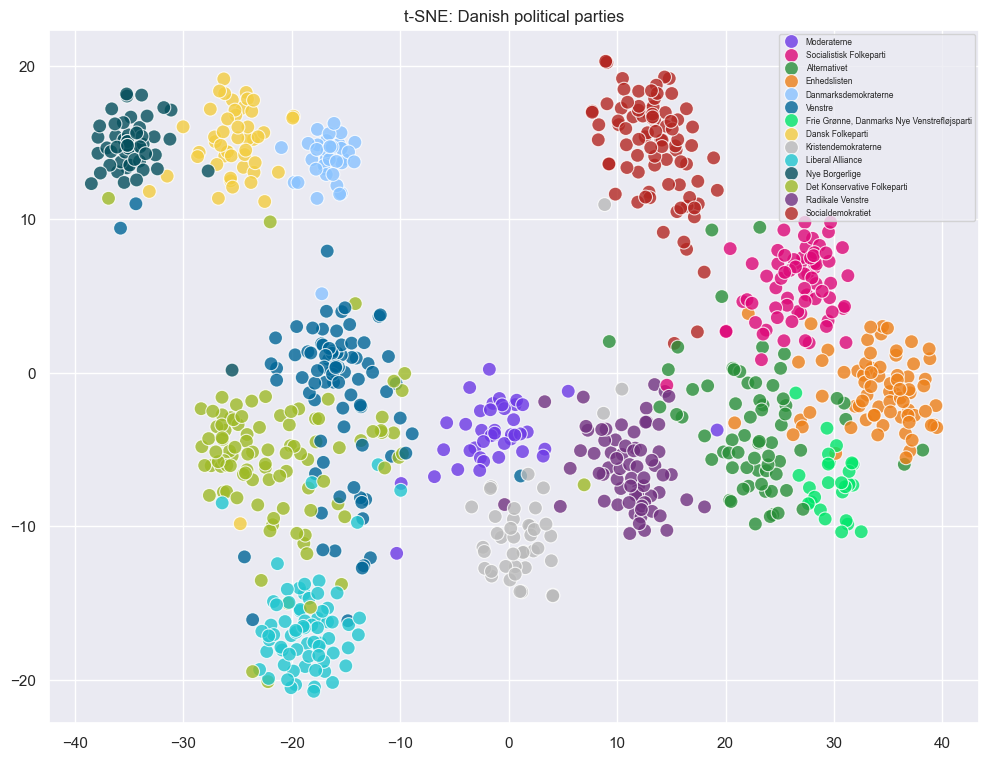

In [193]:
tsne = TSNE(perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

def visualize_2d_tsne(x, labels, cols):
    sns.set_theme(rc={'figure.figsize':(12,9)})
    g= sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=cols, s=100, alpha=0.8)
    plt.title("t-SNE: Danish political parties")
    g.legend(fontsize=6)
    
visualize_2d_tsne(X_tsne, labels, parti_colors)

Here we can clearly see Dansk Folkeparti, Nye Borgerlige, and Danmarksdemokraterne in a distinct cluster, suggesting ideological differences within the right-wing block.

Socialdemokratiet also appears somewhat isolated from other left-leaning parties. As a center-left party it should not be separated that obviously.

Overall the graphs both from PCA and t-SNE look very good and do very well on separating the parties. Now we will move on looking at average positions of parties in the PCA composition using the first 5 questions from the first 2 components.

# Average positions of parties compared to questions

First we will start with some data preparation. Then we will plot the graphs and see what is the result.

In [194]:
component1_questions = combined_q[combined_q['ID'].isin(component_1_features)]
component2_questions = combined_q[combined_q['ID'].isin(component_2_features)]

relevant_data = data[['parti'] + component1_questions['ID'].tolist() + component2_questions['ID'].tolist()]


average_positions_pc1 = relevant_data.groupby('parti')[component1_questions['ID']].mean()
average_positions_pc2 = relevant_data.groupby('parti')[component2_questions['ID']].mean()

average_positions = pd.concat([average_positions_pc1, average_positions_pc2], axis=1).T

#rename of one of the parties so there is more space for the plots
average_positions = average_positions.rename(columns={'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'FG, D Nye Venstrefløjsparti'})
parti_colors['FG, D Nye Venstrefløjsparti'] = parti_colors.pop('Frie Grønne, Danmarks Nye Venstrefløjsparti')
labels = labels.replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'FG, D Nye Venstrefløjsparti')
average_positions

parti,Alternativet,Danmarksdemokraterne,Dansk Folkeparti,Det Konservative Folkeparti,Enhedslisten,"FG, D Nye Venstrefløjsparti",Kristendemokraterne,Liberal Alliance,Moderaterne,Nye Borgerlige,Radikale Venstre,Socialdemokratiet,Socialistisk Folkeparti,Venstre
530,1.880597,-0.837838,-0.571429,-0.836735,1.959459,1.923077,0.880952,-1.142857,0.642857,-1.098039,1.402985,0.574713,1.857143,-0.642857
537,-1.641791,0.189189,0.000000,1.408163,-1.878378,-2.000000,-0.428571,1.900000,0.619048,1.705882,-0.522388,-1.022989,-1.885714,0.857143
550,1.149254,-1.756757,-1.673469,-1.704082,1.418919,1.807692,-1.666667,-1.928571,0.261905,-1.980392,0.835821,0.367816,1.271429,-1.357143
3b,1.477612,-1.864865,-1.816327,-1.214286,1.743243,1.807692,1.452381,-1.442857,-0.166667,-1.960784,1.432836,-0.241379,1.542857,-1.011905
4a,1.746269,0.108108,0.448980,-0.948980,2.000000,2.000000,0.738095,-1.628571,0.095238,-0.960784,0.880597,1.172414,1.885714,-0.345238
551,-1.761194,1.756757,1.775510,-0.816327,-1.743243,-2.000000,-1.642857,-1.271429,-1.238095,1.882353,-1.925373,-0.045977,-1.600000,-0.916667
553,-0.462687,1.216216,0.877551,-0.224490,0.054054,-1.576923,0.857143,-1.257143,-1.023810,0.980392,-1.253731,0.977011,0.542857,0.130952
556,-0.910448,-1.918919,-1.510204,1.744898,-1.864865,-1.846154,1.261905,1.928571,1.428571,-0.647059,0.014925,-1.885057,-1.914286,-0.154762
4b,0.701493,1.108108,1.408163,0.530612,1.432432,1.000000,0.023810,-1.128571,-0.071429,0.823529,-0.074627,0.804598,1.257143,0.404762
10b,1.029851,1.918919,1.448980,-1.612245,1.905405,1.615385,-1.333333,-1.928571,-1.142857,0.666667,-0.223881,1.896552,1.814286,0.095238


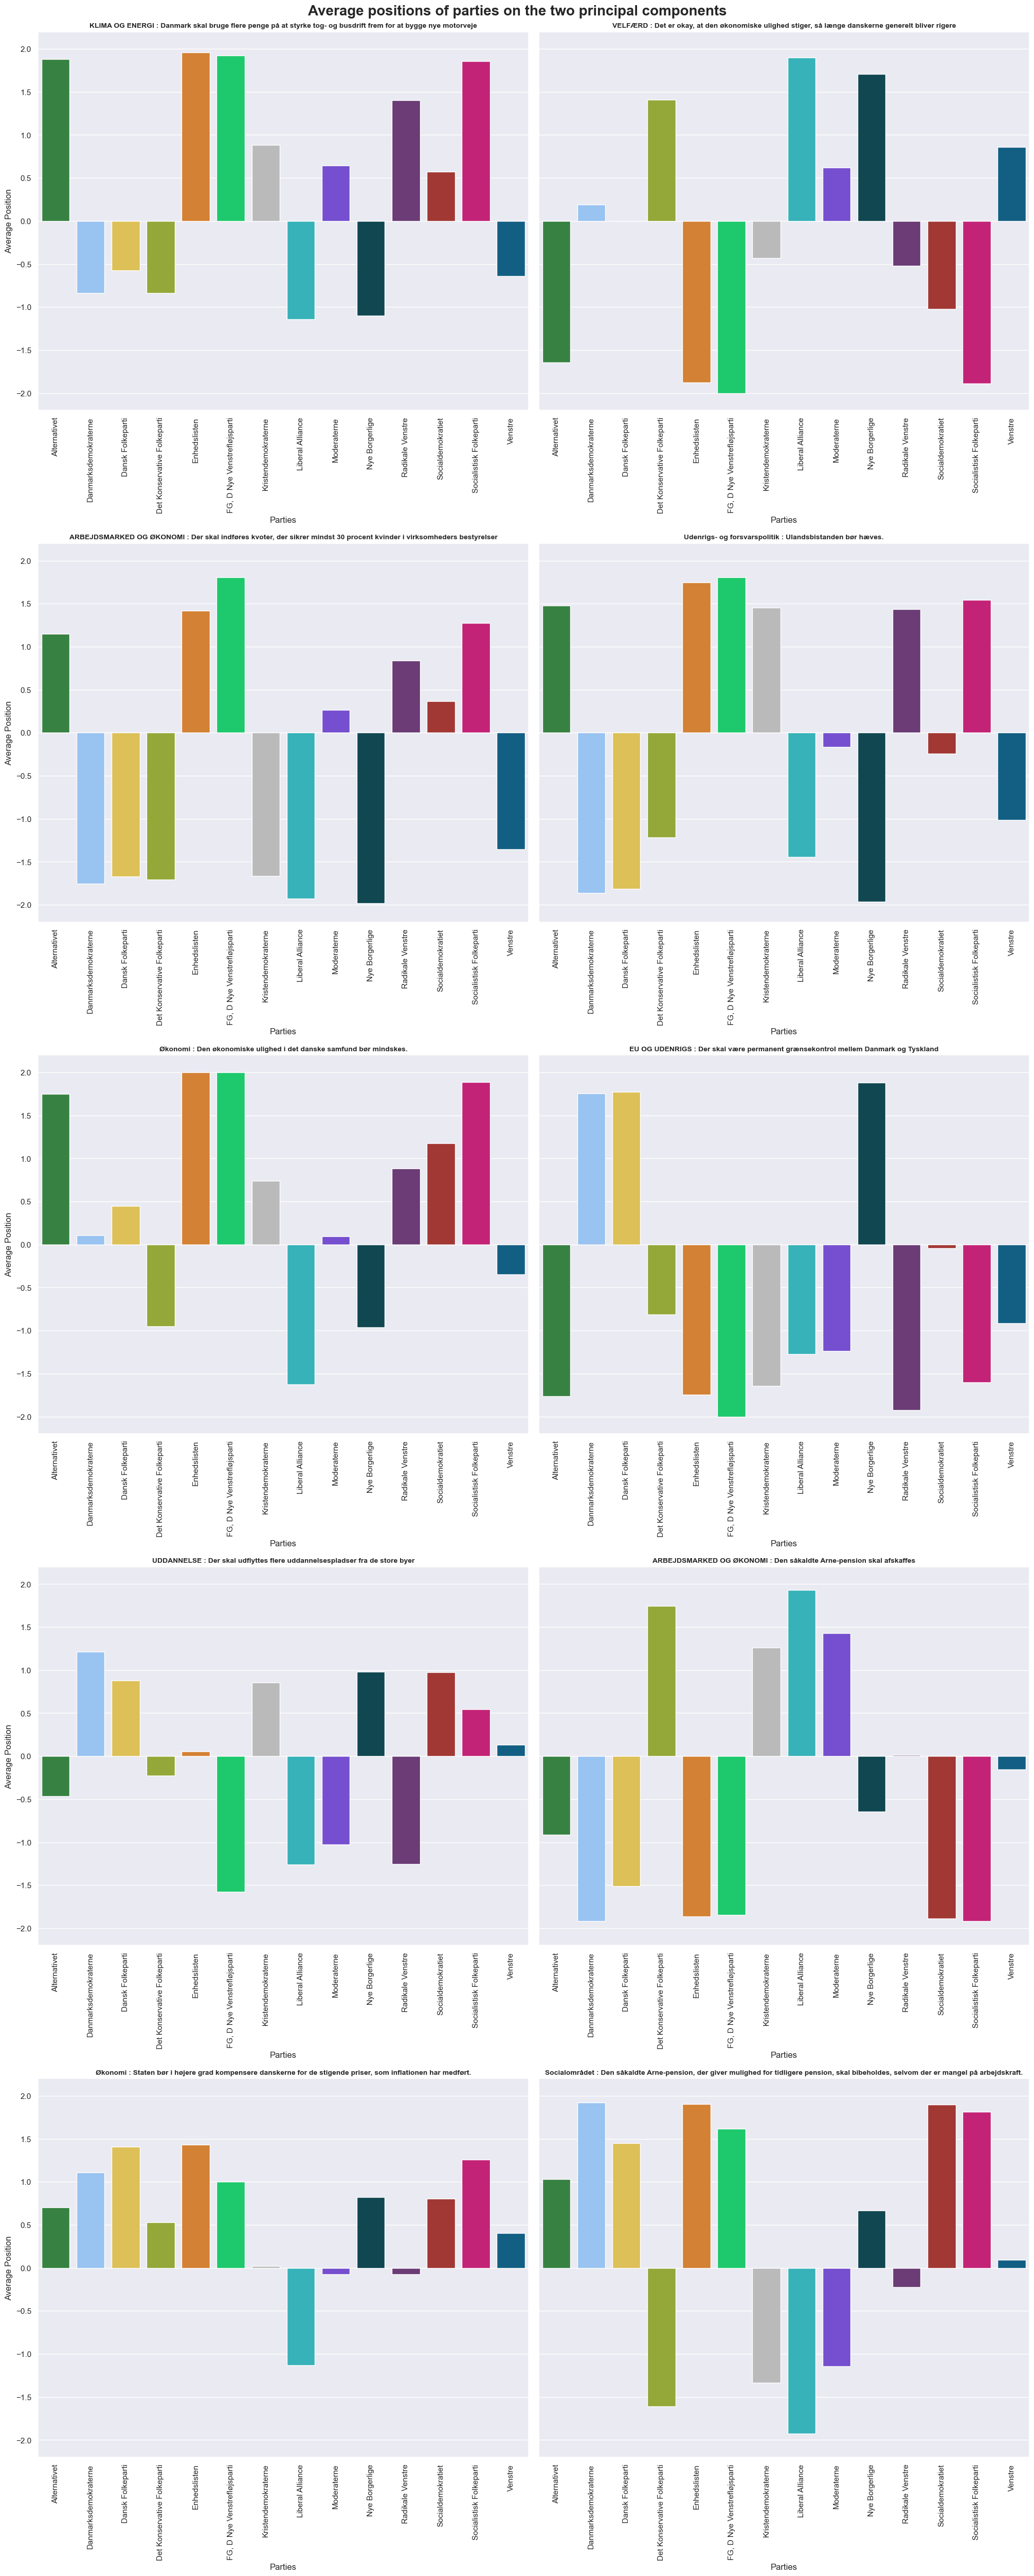

In [195]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 50), sharey=True, constrained_layout=True)

# plotting the graphs
for ax, question_id in zip(axes.flat, average_positions.index):
    sns.barplot(ax=ax, x=average_positions.columns, y=average_positions.loc[question_id], hue=average_positions.columns, palette=parti_colors, errorbar=None)
    title = combined_q[combined_q['ID'] == question_id][['Title','Question']].values[0]
    ax.set_title(f'{title[0]} : {title[1]}', fontweight='bold', fontsize=10)
    ax.set_ylabel('Average Position')
    ax.set_xlabel('Parties')
    ax.tick_params(axis='x', rotation=90)
    fig.suptitle('Average positions of parties on the two principal components',fontweight='bold', fontsize=20)

plt.show()

In the plot, the first five graphs represent the top questions from Component 1 of our PCA. The second set of five graphs shows the key questions from Component 2. We can clearly see a divide between right- and left-wing parties in the first set of graphs (Component 1). Although this contrast is less distinct in the second set (Component 2), the pattern is still noticeable.

The PCA captures well the variation in these questions, making it easier to see how parties differ in their positions. This provides a strong start for the next step: clustering.

In this analysis, we’ve grouped all candidates within each party to find their average scores, which treats each party as a single entity. In clustering, however, we’ll analyze individual candidates directly based on their responses. If party members are consistent in their answers, clustering should group them together. But if opinions vary widely within a party, some candidates may fall into different clusters.

We’re interested to see if parties with similar average scores on these questions end up close to each other in the clustering results.

# Clustering 

For the clustering we will use both PCA and t-SNE to see which will be better for the clustering. We will use three different clustering algorithms - K-means, Hierarchical Clustering and DBSCAN.

## K-means

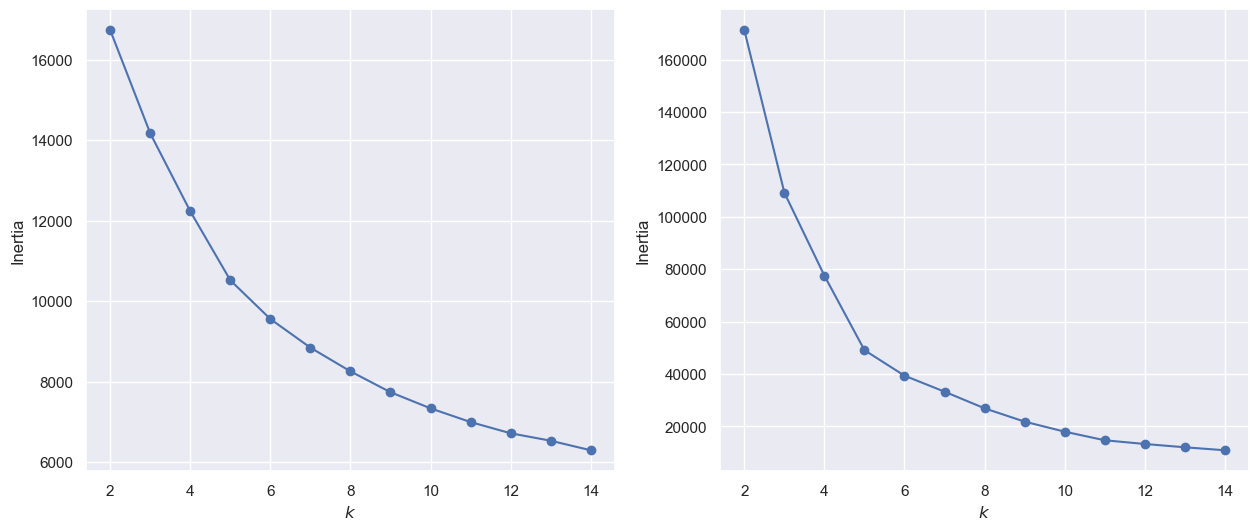

In [196]:
cluster_range = range(2, 15)

kmeans_per_k_pca = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_pca)
                for k in cluster_range]

kmeans_per_k_tsne = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_tsne)
                for k in cluster_range]

inertias_pca = [model.inertia_ for model in kmeans_per_k_pca]
inertias_tsne = [model.inertia_ for model in kmeans_per_k_tsne]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
ax.plot(cluster_range, inertias_pca, "bo-")
ax.set_xlabel("$k$")
ax.set_ylabel("Inertia")
ax.grid(True)

ax = axes[1]
ax.plot(cluster_range, inertias_tsne, "bo-")
ax.set_xlabel("$k$")
ax.set_ylabel("Inertia")
ax.grid(True)

plt.show()

From the first graph it is harder to see how many clusters we need, but it seems like between 5 and 8 somewhere. From the second graph it is more clear that probably would be 5 clusters. We can also try silhouette measurement provided by scikit-learn to try and see more precisely how much clusters do we need for K-means.

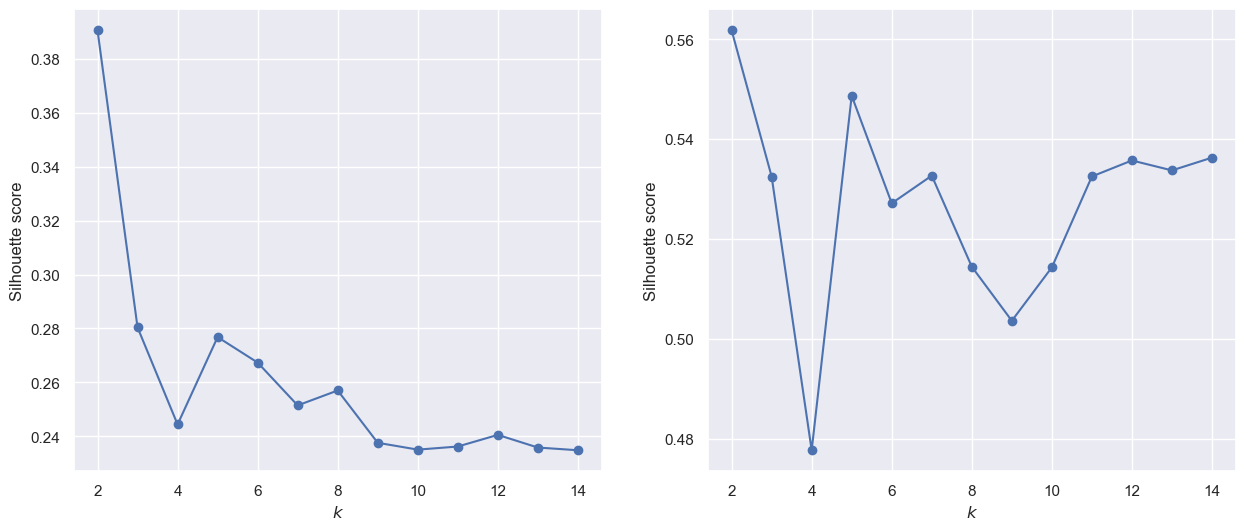

In [197]:
silhouette_scores_pca = [silhouette_score(X_pca, model.labels_)
                        for model in kmeans_per_k_pca]

silhouette_scores_tsne = [silhouette_score(X_tsne, model.labels_)
                        for model in kmeans_per_k_tsne]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
ax.plot(cluster_range, silhouette_scores_pca, "bo-")
ax.set_xlabel("$k$")
ax.set_ylabel("Silhouette score")
ax.grid(True)

ax = axes[1]
ax.plot(cluster_range, silhouette_scores_tsne, "bo-")
ax.set_xlabel("$k$")
ax.set_ylabel("Silhouette score")
ax.grid(True)

plt.show()

As we mentioned before when looking at the PCA graph there is a separation between the left- and right-wing parties which is very clear. Here we also can see that as the 2 clusters score very high compared to the others. If we ignore that we can see that now we have 3 in second place and 5 very close to it. 5 is also the second highest in the tsne data. 6 also looks good for clusters. Because there is no distinguished choice we will use silhouette diagram on the PCA (because it is harder to determine there) to further try and see which number of clusters to use.

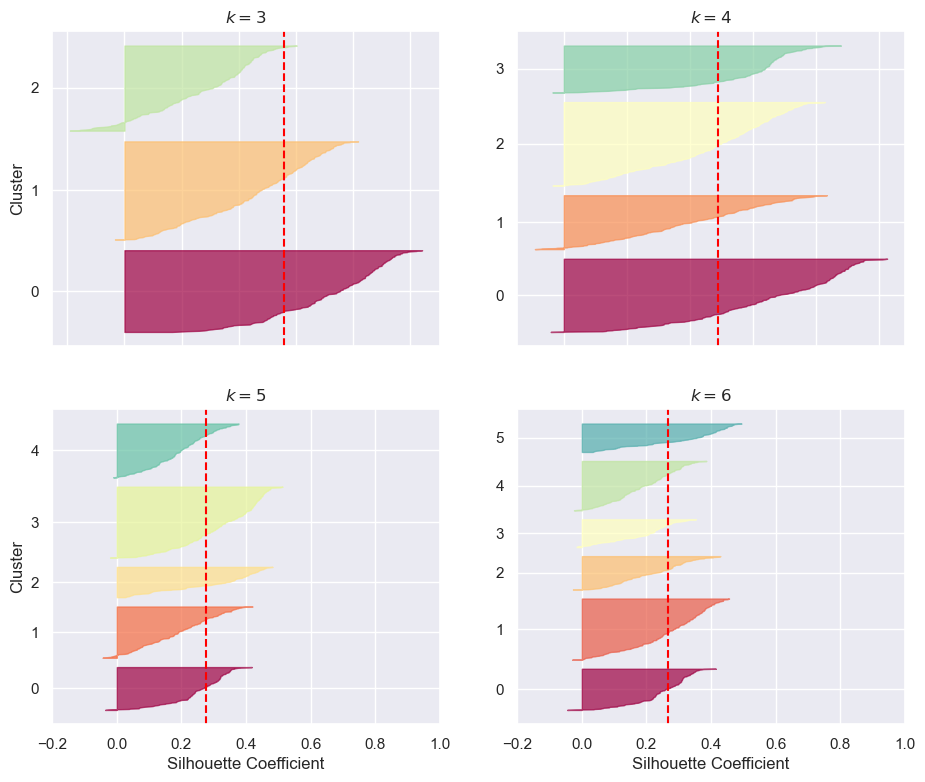

In [198]:
# Code from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k_pca[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_pca, y_pred)

    padding = len(X_pca) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_pca[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

From the graphs we can see that setting the clusters to 6 could benefit in more proportional clusters. The results from 5 clusters will be also good but the 3rd cluster would be quite big compared to the others. We will try both 5 and 6 clusters.

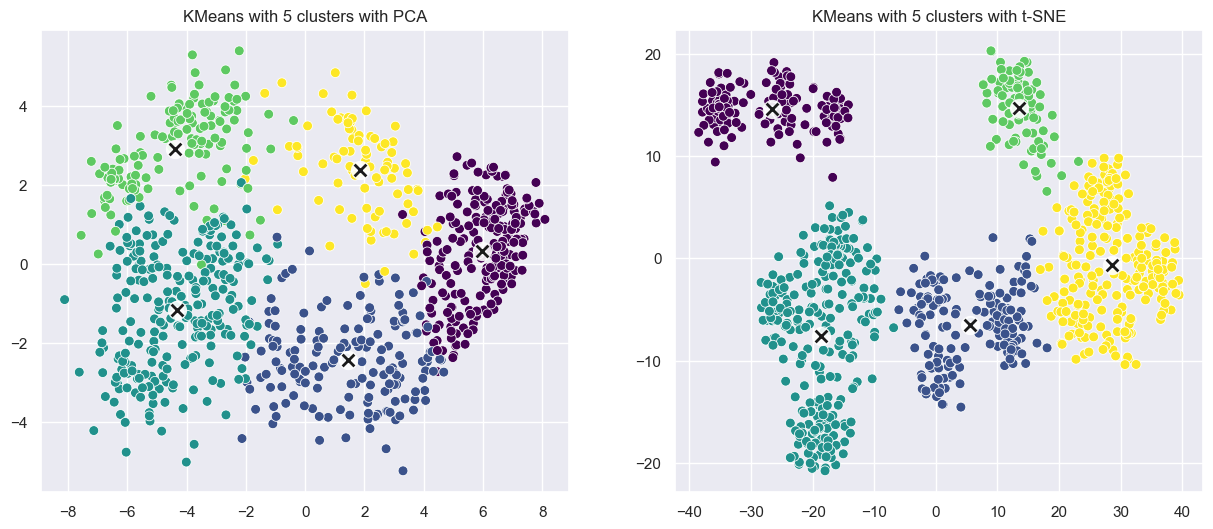

In [211]:
def plot_centroids(centroids, ax, circle_color='w', cross_color='k'):
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9, ax=ax)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1, ax=ax)

def plot_k_means(kmeans, datasets, labels):

    fig, axes = plt.subplots(1, len(kmeans), figsize=(15, 6))

    for i, (k, dataset, label) in enumerate(zip(kmeans, datasets, labels)):
        ax = axes[i]
        sns.scatterplot(x=dataset[:, 0], y=dataset[:, 1], hue=k.labels_, s=50, palette='viridis', ax=ax)
        centers = k.cluster_centers_
        plot_centroids(centers, ax)
        ax.set_title(f'KMeans with {k.n_clusters} clusters with {label}')
        ax.legend_.remove()
    
    plt.show()

kmeans_clusters = 5

plot_k_means([kmeans_per_k_pca[kmeans_clusters-2], kmeans_per_k_tsne[kmeans_clusters-2]], [X_pca, X_tsne], ['PCA', 't-SNE'])

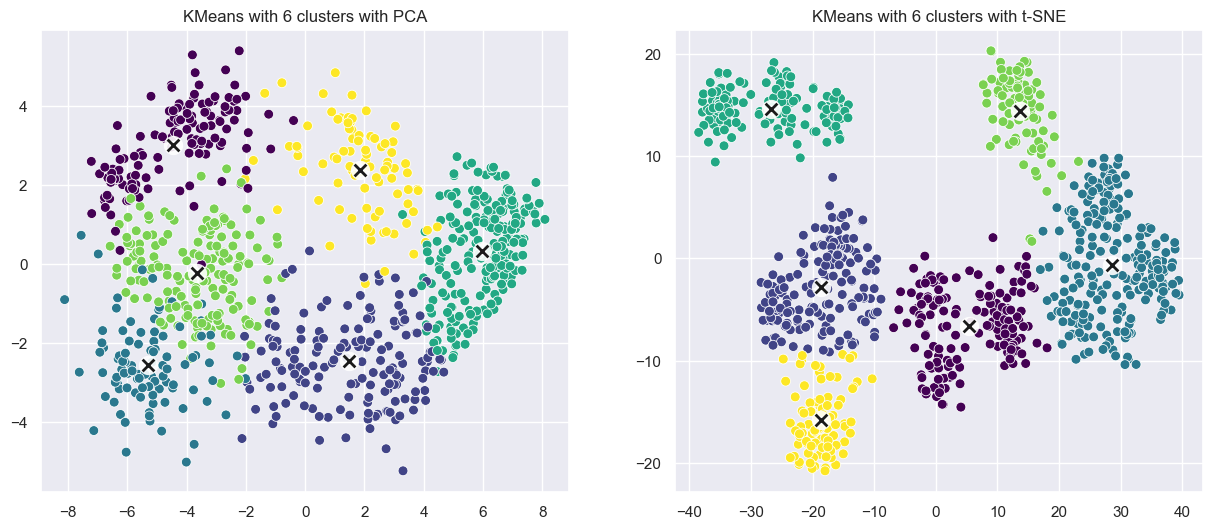

In [212]:
kmeans_clusters = 6

plot_k_means([kmeans_per_k_pca[kmeans_clusters-2], kmeans_per_k_tsne[kmeans_clusters-2]], [X_pca, X_tsne], ['PCA', 't-SNE'])

Both KMeans graphs look great. The clustering with t-SNE dataset gives more visually separated clusters. We think that 5 clusters would be benefitial in this case as the parties can be separated in groups as follows: Far-Right, Right, Central, Left, Far-Left or Right, Right-Central, Central, Left-Central, Left. We are not sure which naming is better that is why we present both as option. 

Because of the better separation provided by the t-SNE dimensionality reduction we decided to try and cluster with 14 clusters (as the number of parties) to see how close it will be to the original t-SNE. We won't try it with the PCA as the data is more spread and it will be harder for simple model like K-means to capture the clusters. Shortly said, we have better chance with t-SNE.

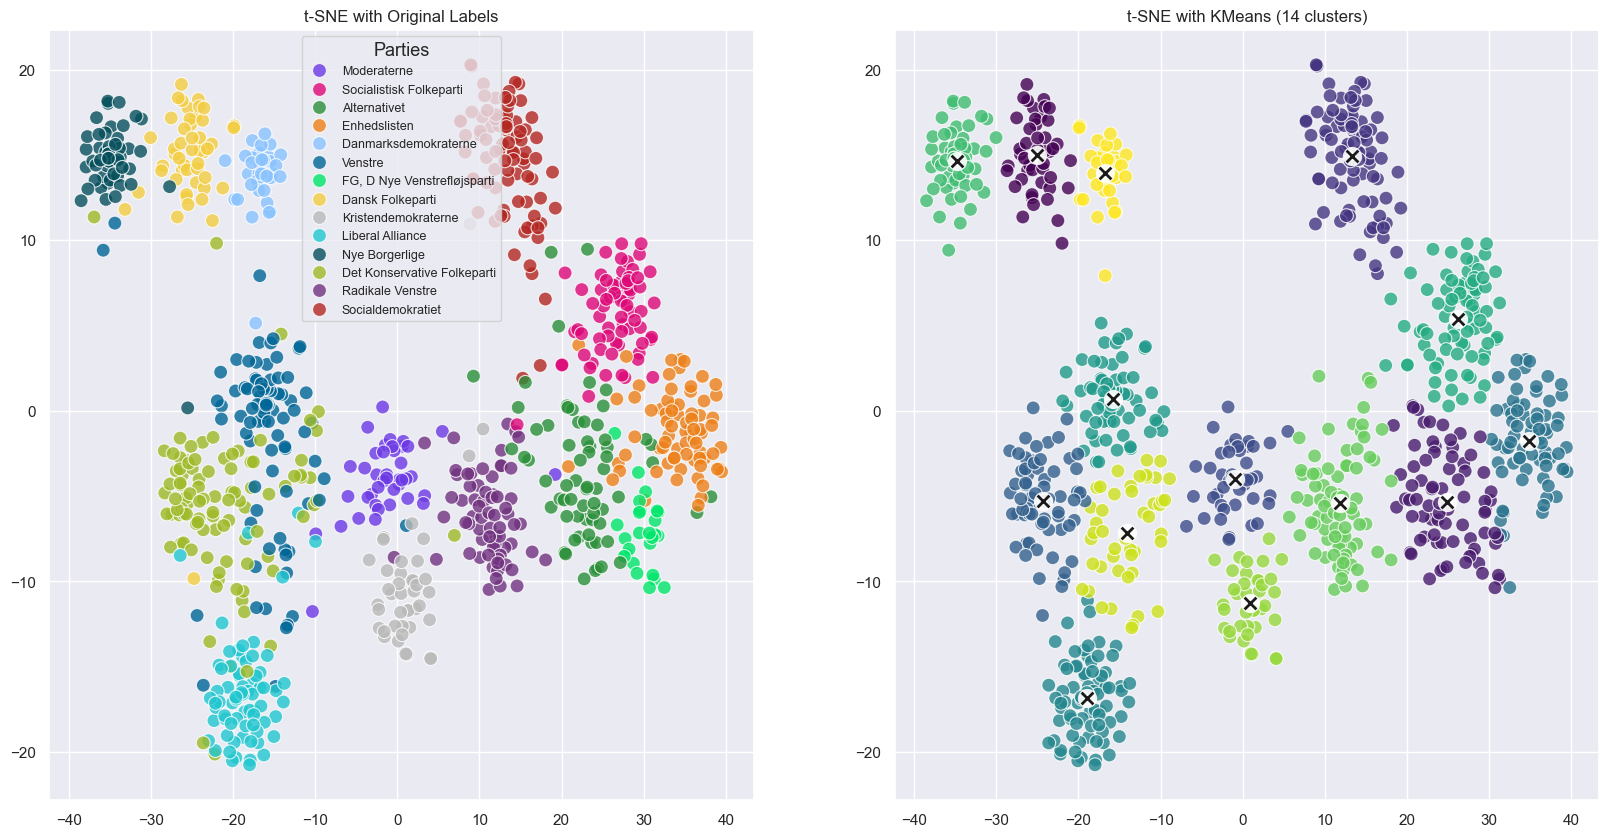

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

kmeans = kmeans_per_k_tsne[-1]

# Plot t-SNE with original labels
sns.scatterplot(ax=axes[0], x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=parti_colors, s=100, alpha=0.8)
axes[0].set_title("t-SNE with Original Labels")
axes[0].legend(fontsize=9, title='Parties', title_fontsize=13)

# Plot t-SNE with KMeans labels
sns.scatterplot(ax=axes[1], x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans.labels_, palette='viridis', s=100, alpha=0.8)
centers = kmeans.cluster_centers_
plot_centroids(centers, axes[1])
axes[1].set_title(f"t-SNE with KMeans ({kmeans.n_clusters} clusters)")
axes[1].legend_.remove()

plt.show()

The 14 clusters in the t-SNE plot on the right perform well, effectively separating candidates based on the party affiliation indicated by their responses. While the clustering cannot perfectly capture outliers (candidates who deviate significantly from their party) it still highlights the main tendencies across groups. We can see that it combined two parties - Venstrefløjsparti and Alternativet and then combined the distant candidates of Venstre and Konservative Folkeparti into 3rd party. From what we see that is where K-means failed to predict. Probably the candidates could think of changing party or rethinking of ideology they want to follow.

Overall, K-means has performed well as a basic clustering model. The next step will be to proceed with hierarchical clustering.

## Agglomerative / Hierarchical clustering

First we will plot dendograms of the 2 datasets to see how many clusters will be there. We are looking for big gaps and long vertical segment between horizontal lines.

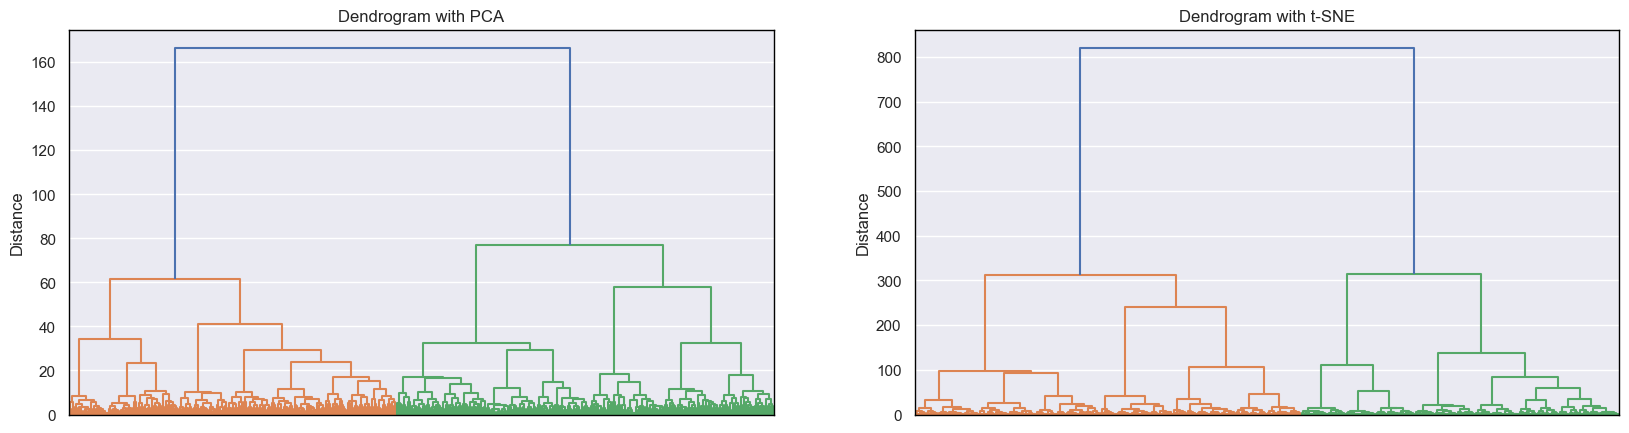

In [203]:
def plot_dendrogram(X_list):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    for i, ax in enumerate(axes):
        linkage_array = linkage(X_list[i], method='ward')
        dendrogram(linkage_array, ax=ax, no_labels=True)
        ax.set_ylabel('Distance')
        ax.set_title(f"Dendrogram with {'PCA' if i == 0 else 't-SNE'}")
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)

plt.show()


plot_dendrogram([X_pca, X_tsne])

Both dendograms show clearly the 2 clusters that the parties form. Another posibility would be 5 clusters as before and this can be seen better in the t-SNE dendogram at 200 Distance. On the PCA dendogram this would be between 40 and 60. So we decided that we will again use 5 clusters for our model.